This notebook is used to perform survival analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting, CoxPHFitter, NelsonAalenFitter
from IPython.display import display

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : True,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,
})

%matplotlib inline

In [2]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 27
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = dropped_na_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/kaplan_meier_comparision/"
print(path_models)
print(path)
print(path_images)

models/27features/
data/27features/
figures/kaplan_meier_comparision/


In [3]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%Y/%m/%d")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
#display(df)

<AxesSubplot:>

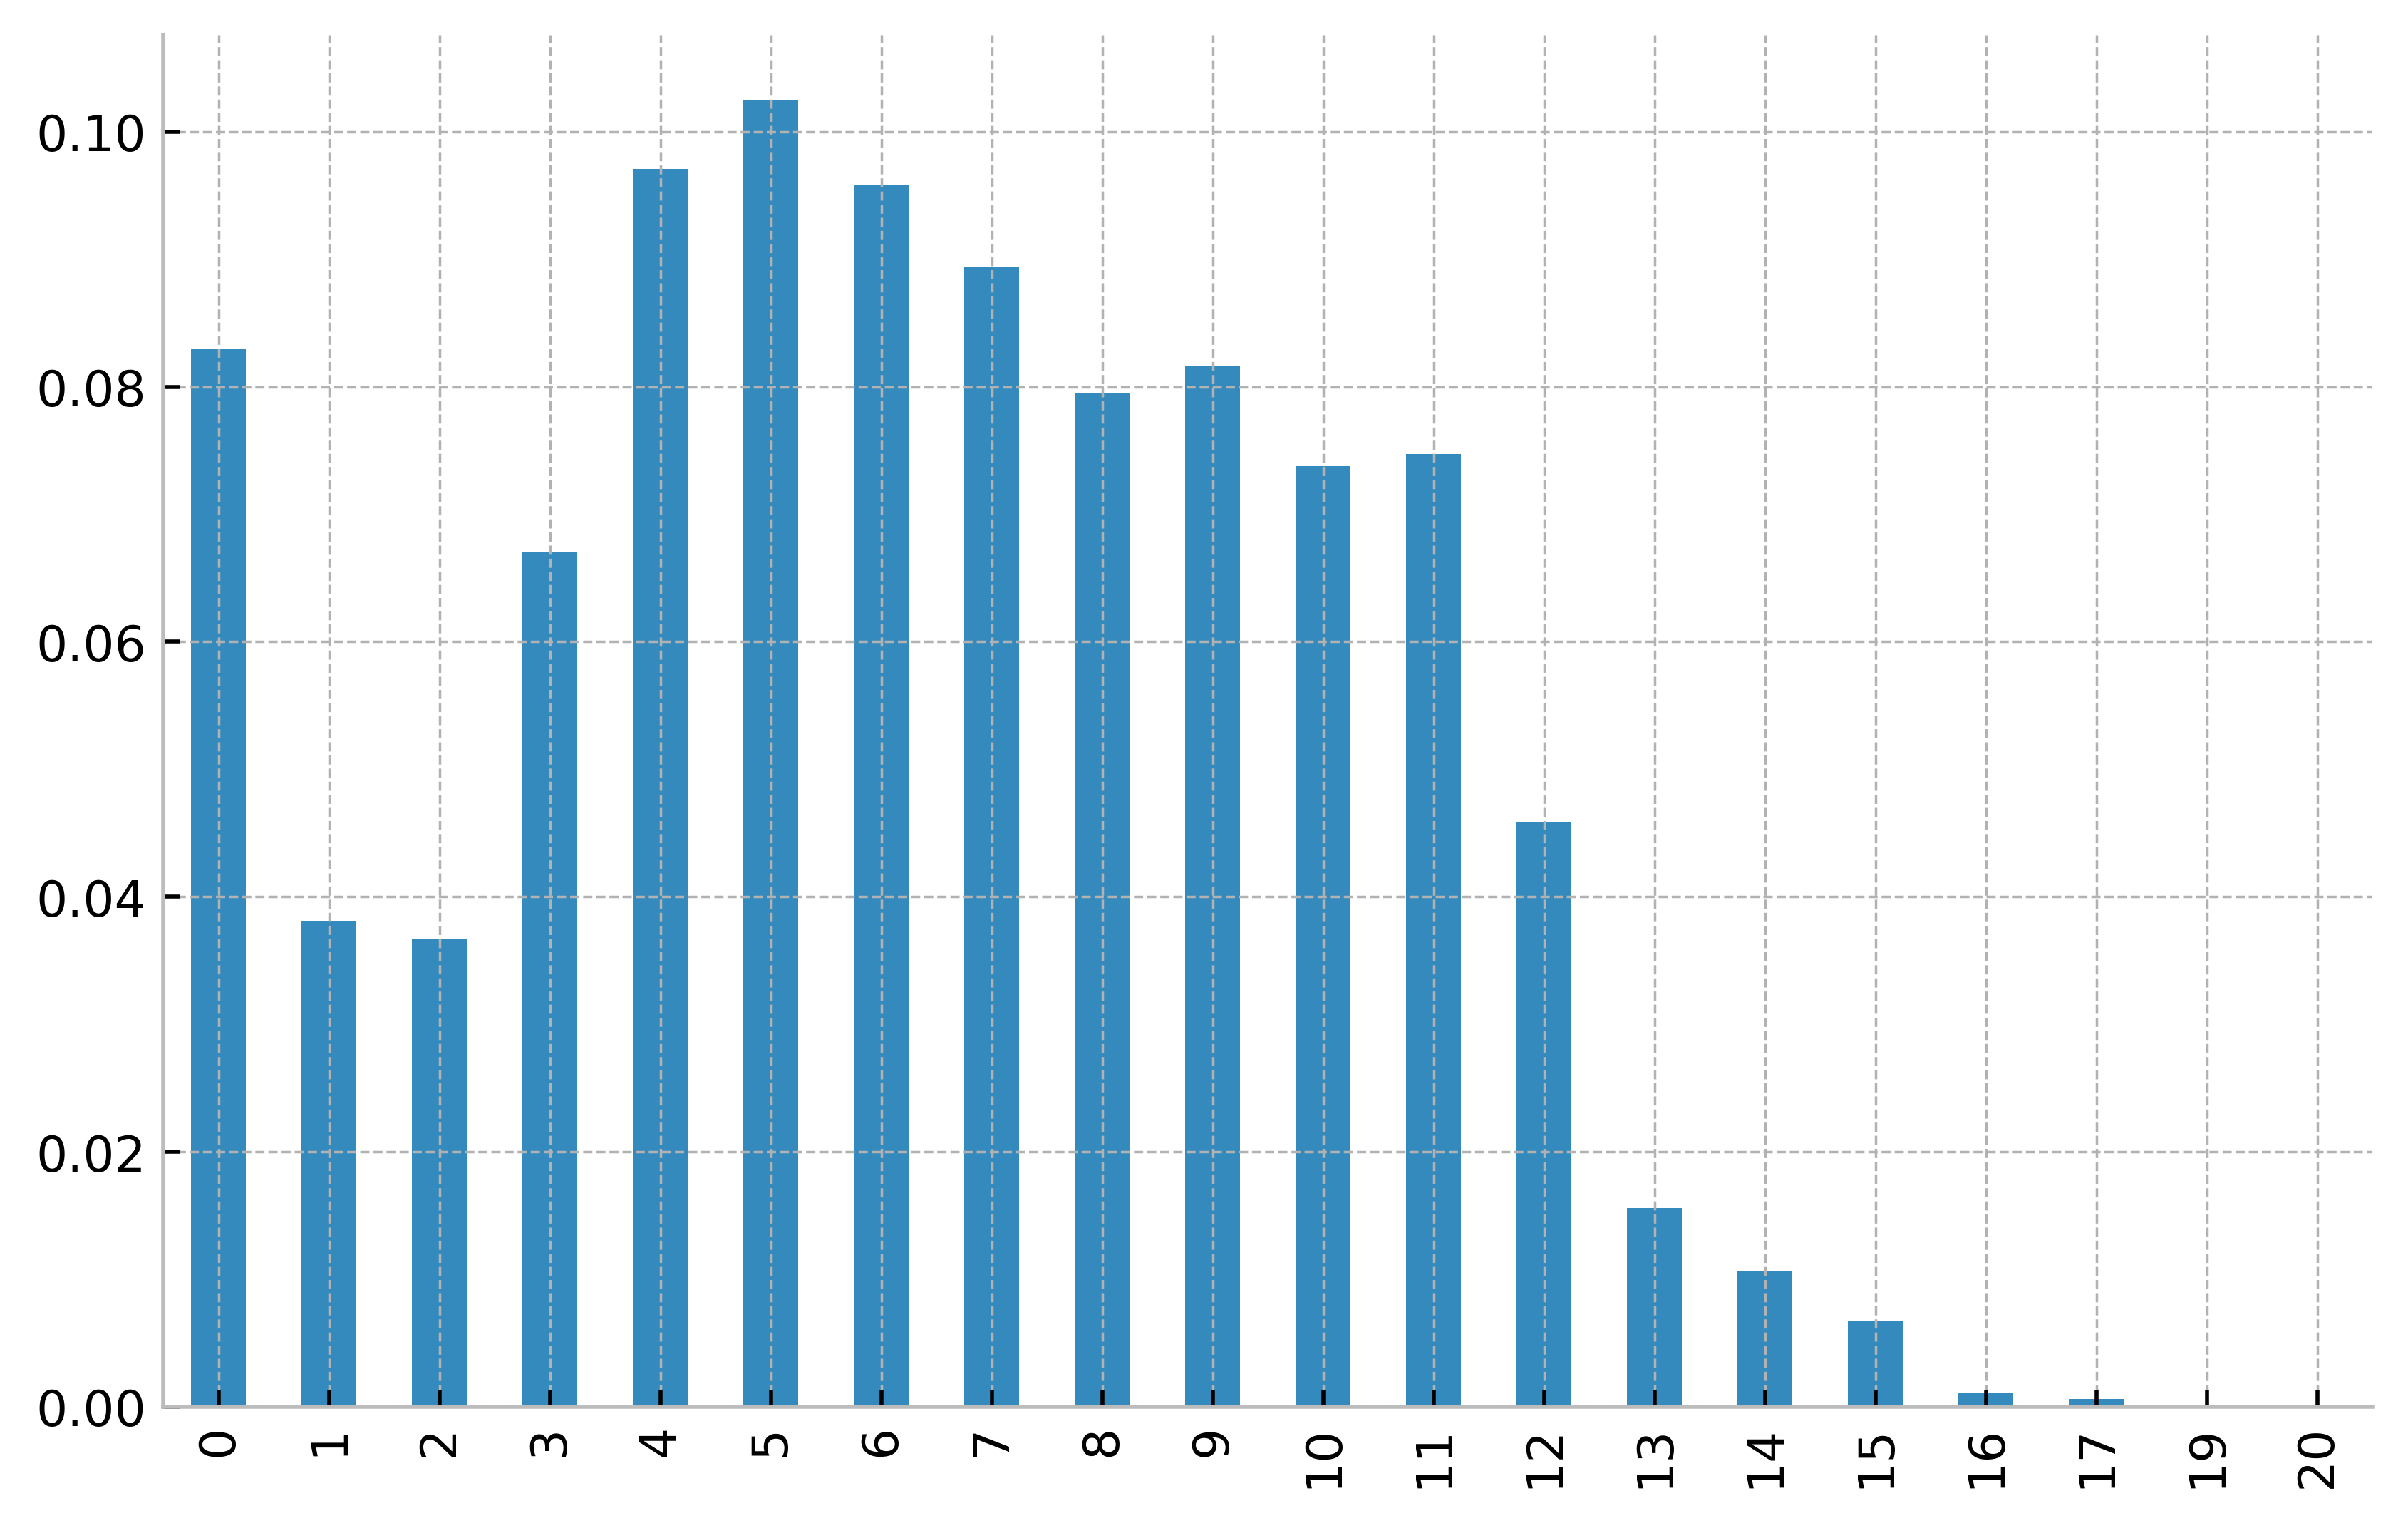

In [4]:
# Birth event: "Data prelievo"
# Death event: "Death7Y"

# Duration and observation features
df_surv = pd.DataFrame()
df_surv["Death7Y"] = df["Death7Y"]
df_surv["duration"] = df_diff
df_surv["observed"] = df["CVD Death"]
df_surv["ID"] = np.random.randint(0, 1e6, size=len(df_surv))
#display(df_surv)
# Plot duration
df_surv["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')
# df_surv.to_csv("data/data_surv.csv")

<AxesSubplot:>

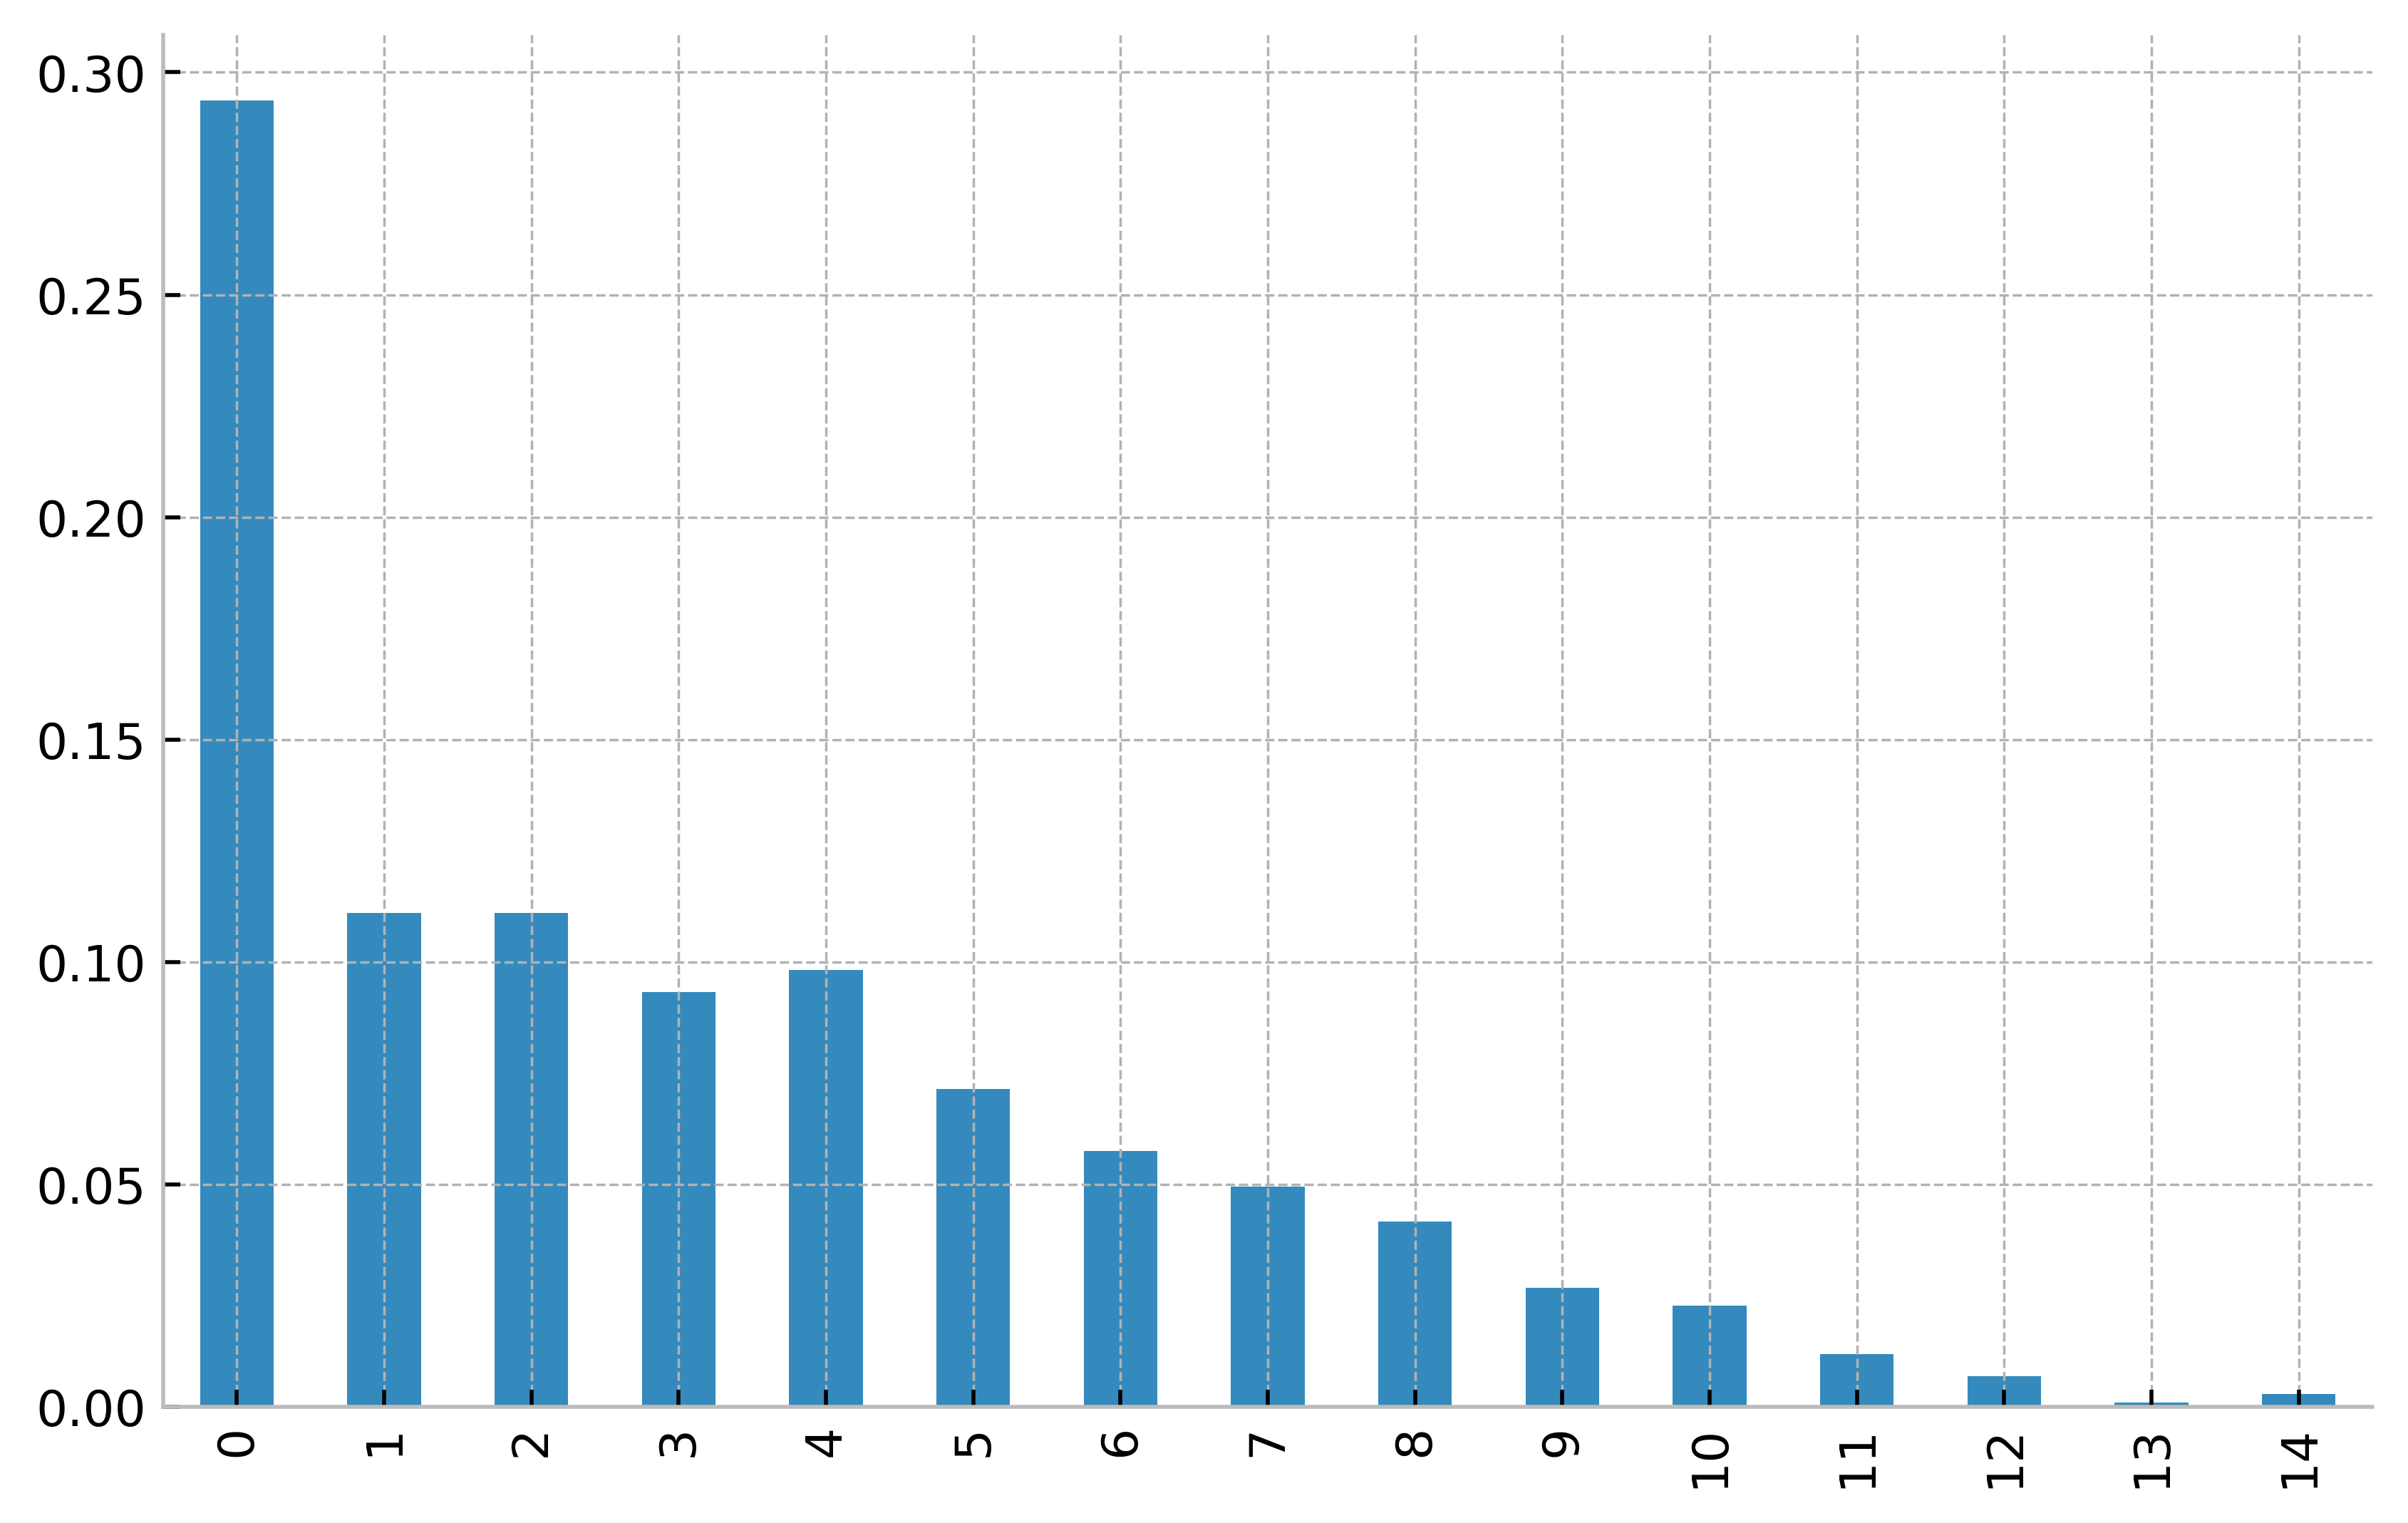

In [5]:
# Data without Right-censoring
#pd.set_option('display.max_rows', 7000)
#display(df_surv[df_surv["observed"]==1])
df_surv[df_surv["observed"]==1]["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')

### Survival Analysis on all the data
The plot indicates the % of CVD patients that survived after n years. 
The probability for surviving more than 7 years is ~86%.

<AxesSubplot:title={'center':'Survival Function of CVD Patients without Right-Censoring'}, xlabel='Years', ylabel='Survive7Y'>

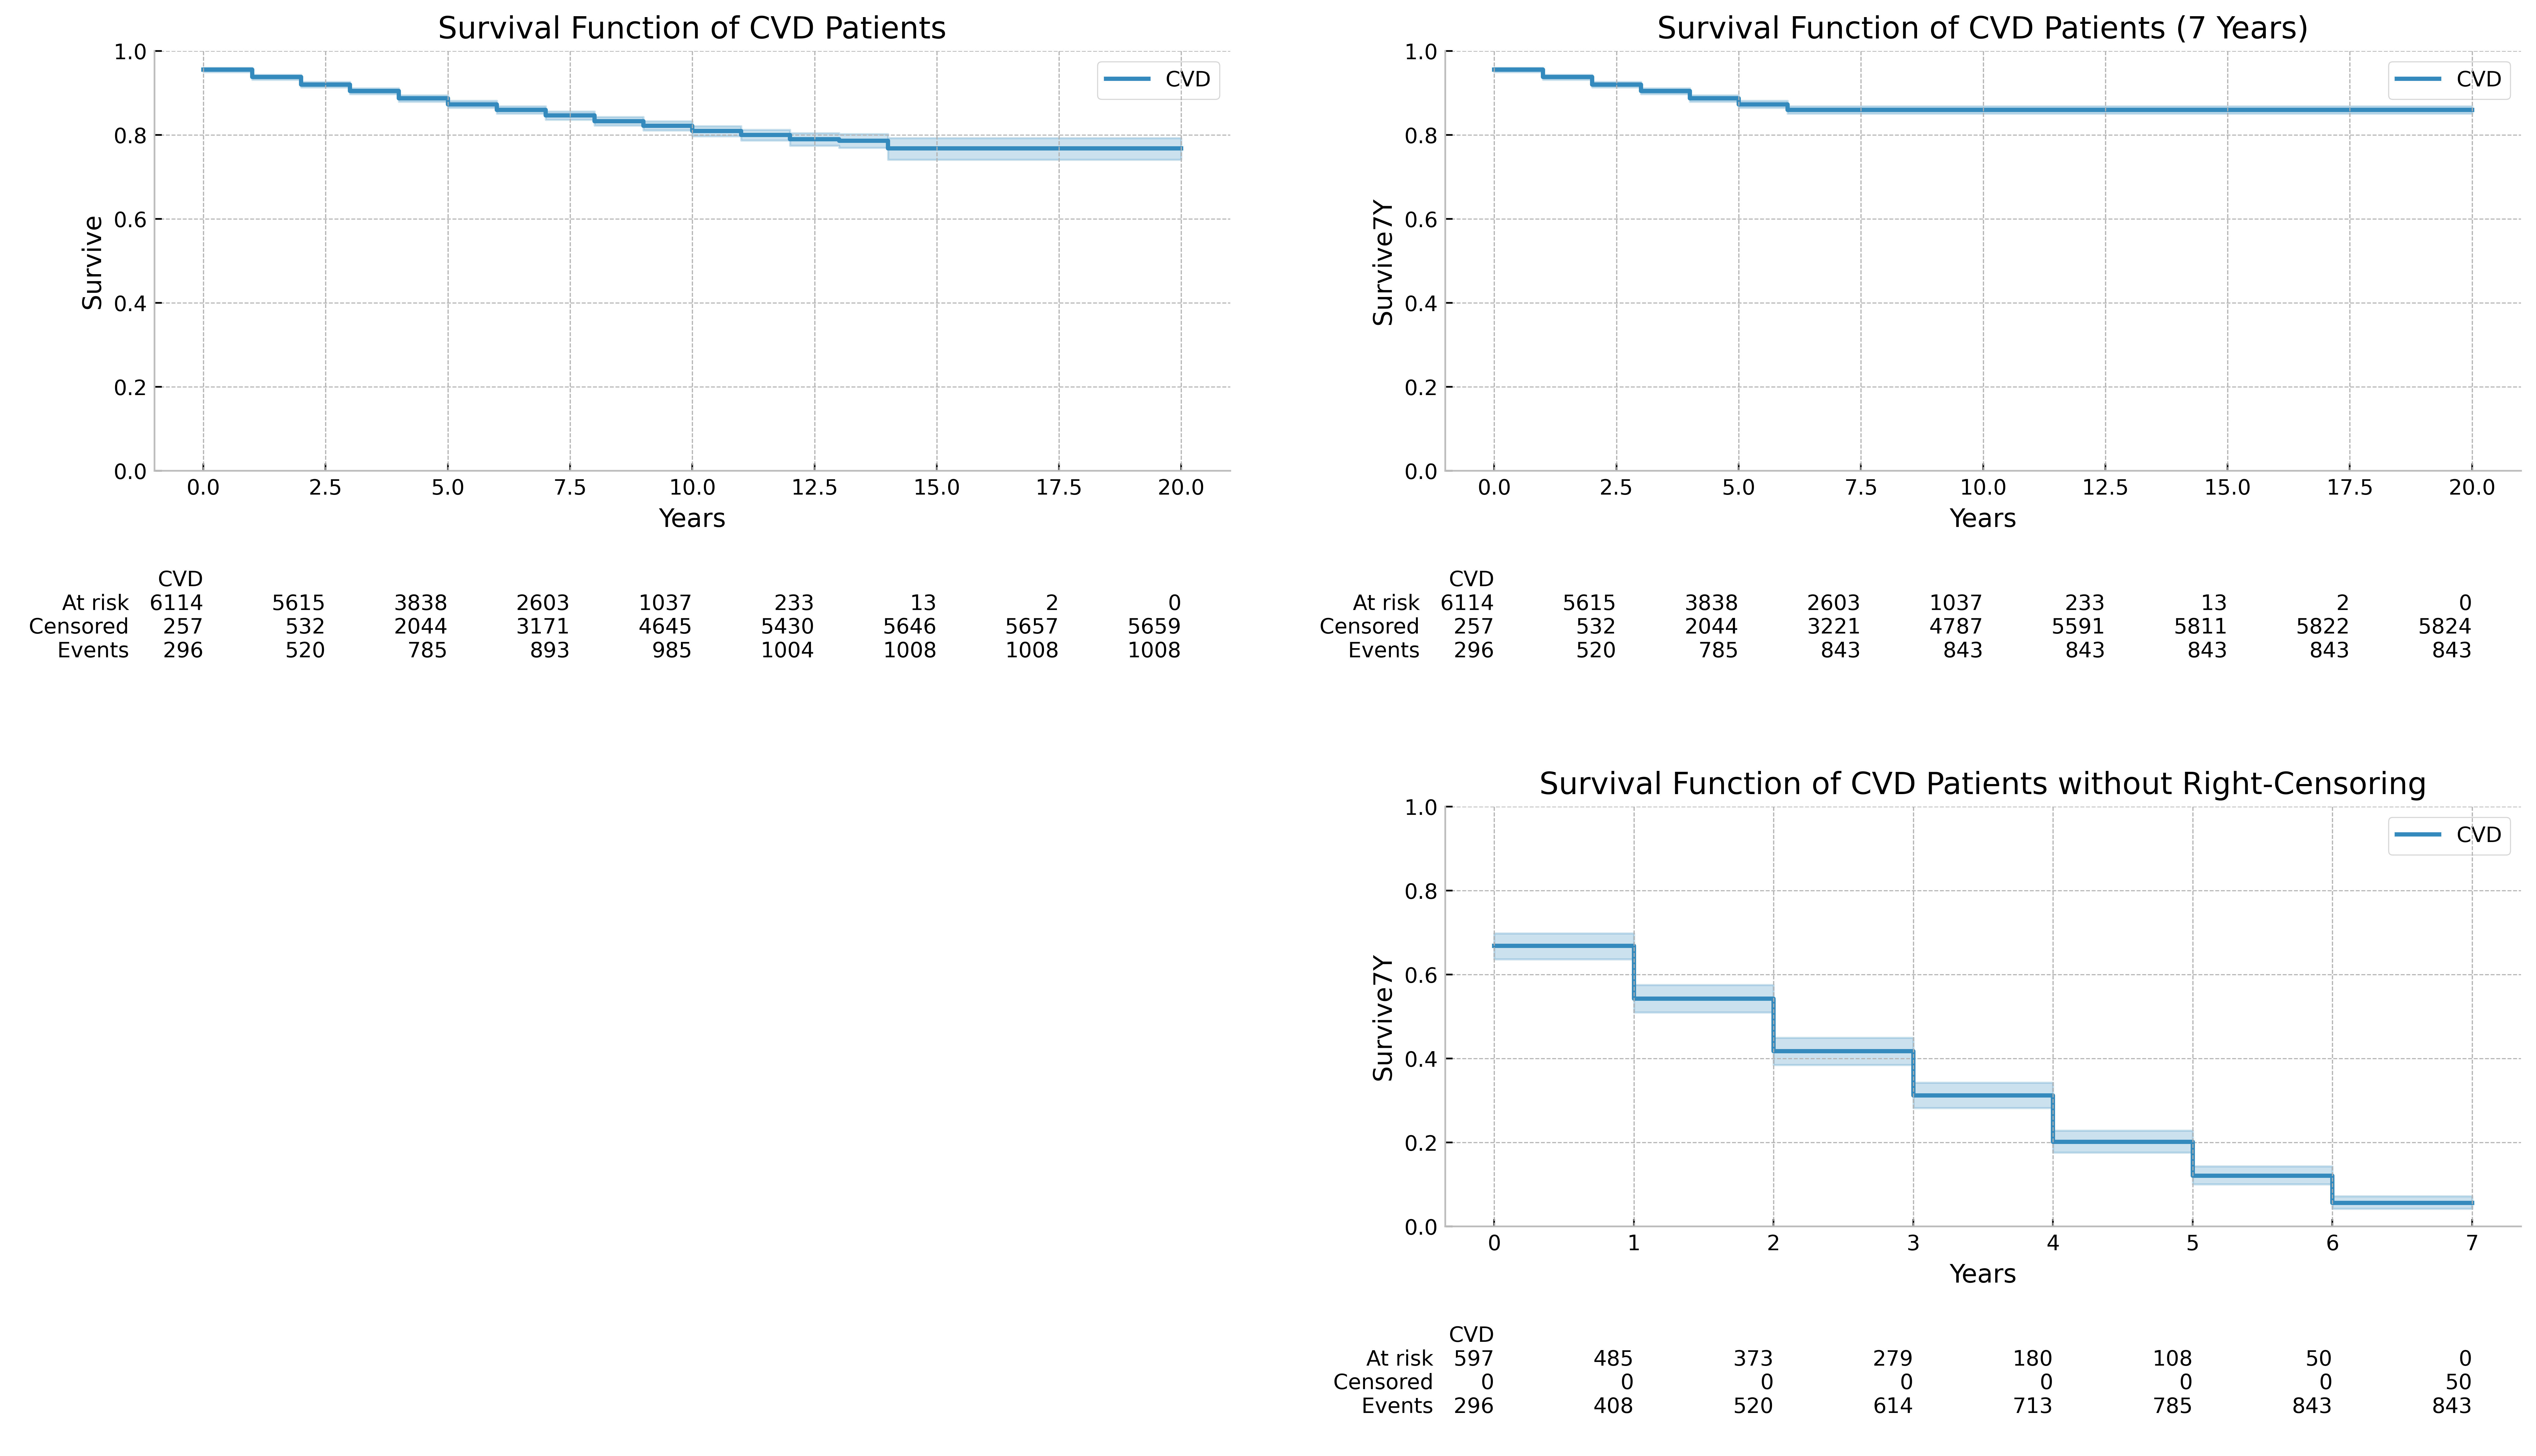

In [6]:
fig = plt.figure(figsize=(20, 10), dpi=500) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)
#display(kmf1.survival_function_at_times(df_surv["duration"].unique()))

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)
#display(kmf2.survival_function_at_times(df_surv["duration"].unique()))


# Without right-censoring
df = df_surv[df_surv["observed"]==1]
df = df[df["duration"]<=7]
plt.subplot2grid(fig_dims, (1, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df["duration"], event_observed=df["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients without Right-Censoring')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

#plt.savefig(f"{path_images}survival_all_par.png")
# kmf.median_survival_time_
# kmf.confidence_interval_

### Survival Analysis Univariate

In [7]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%Y/%m/%d")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
df["duration"] = df_diff
df["observed"] = df["CVD Death"]

# Remove columns that were not found within the old dataset
to_drop = ['Glycemia', 'Primary Dilated\nCardiomyopathy', 'Normal', 'SindromeX', 'AMI', 'PMI', 'Aritmie', 'MIN', 'MIO', 'Miocardite', 'Pericardite', 'Endocardite', 'Valvulopatie', 'MalattiaVasoAorta', 'Ipertensione', 'CardiopatiaCongenita', 'EmboliaPolmonare', 'EPA', 'HR', 'Weight', 'Height', 'BMI', 'Diastolic blood pressure', 'Systolic blood pressure', 'WmsiBas', 'DimSettoIV', 'DimPP', 'vsx', 'B-Blockers', 'Amiodarone', 'Calcium channel blockers', 'Diuretics', 'Antiplatelet', 'Nitrates', 'ACE-inhibitors', 'Ipolipemizzanti', 'Antidiabetici', 'Cause of death', 'Collected by', 'Suicide', 'CABG ', 'Non Fatal AMI (Follow-Up)', 'Ictus', 'PCI']

#Columns with missing values
drop_columns_missing = ['Total cholesterol', 'HDL', 'LDL', 'Triglycerides', 'Creatinina']

# Not useful columns
nu_columns = ["Data of death", "Data prelievo", "Follow Up Data",
                                "Fatal MI or Sudden death", "UnKnown", "Accident", "Total mortality", 
                                "CVD Death", "CAD"]
df = df.drop(columns = to_drop + drop_columns_missing + nu_columns)
print(len(df.columns)) 
assert len(df.columns) == 30
#display(df)

30


30
0 Gender (Male = 1)
0.1121 0.11205343673508793 2263 4404
1 Age
0.0 4.622764261637793e-73 3076 3591
2 TSH
0.0004 0.0004007937566208717 4507 2160
3 fT3
0.0 5.1158675347401726e-14 3992 2675
4 fT4
0.0 6.432672345161364e-26 3913 2754
5 Euthyroid
0.0 1.6412709165372008e-40 1816 4851
6 Subclinical primary hypothyroidism (SCH)
0.0 2.058404733270715e-08 6295 372
7 Subclinical primary hyperthyroidism
(SCT)
0.5349 0.5349401843222317 6462 205
8 Low T3
0.0 1.8027242533777986e-26 5648 1019
9 Ipotiroidismo
0.0053 0.0052663892232573985 6567 100
10 Ipertiroidismo
0.0049 0.004871816319431292 6546 121
11 Angina
0.0042 0.00416407058208963 3219 3448
12 Previous CABG
0.0 3.5222927809800494e-32 6145 522
13 Previous PCI
0.0371 0.03712980806176076 5781 886
14 Previous Myocardial Infarction
0.0 3.6416233621839285e-29 5015 1652
15 Acute Myocardial Infarction
0.0 1.266222174568919e-09 6054 613
16 Angiography
0.0 8.054073764592256e-06 2509 4158
17 Vessels
0.0346 0.034589406417466 3982 2685
18 Documented resting

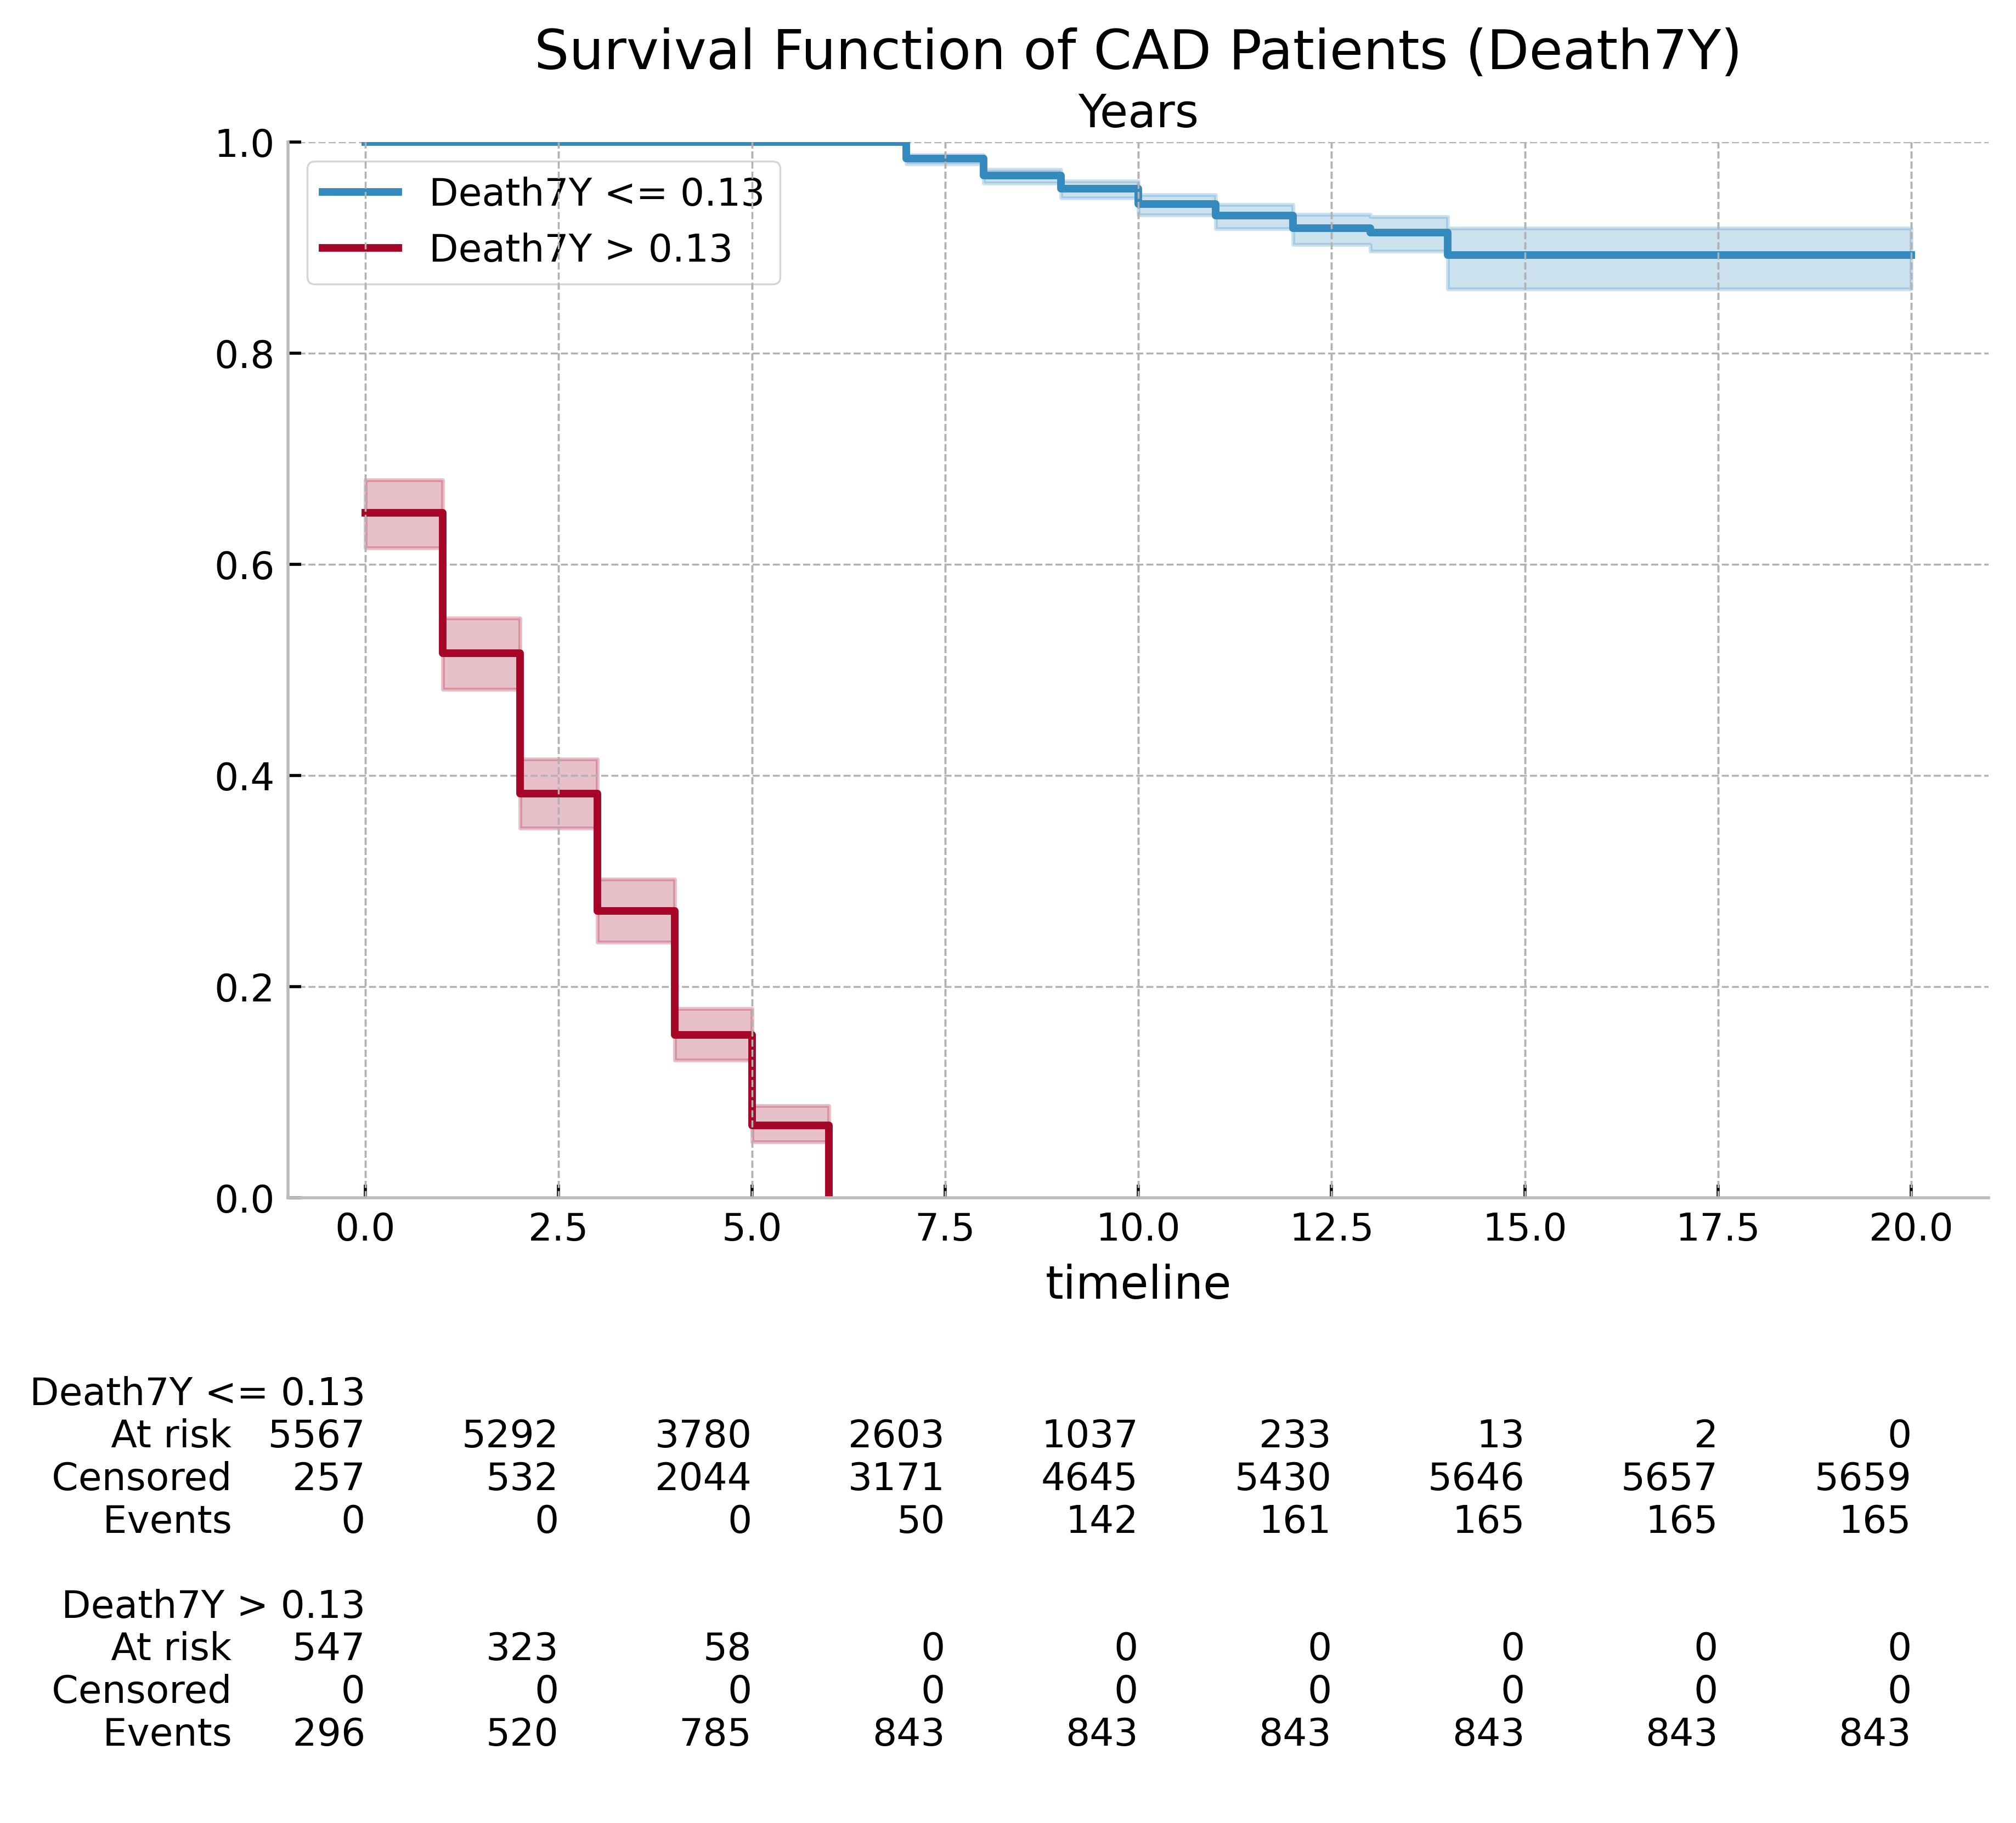

In [8]:
#fig = plt.figure(figsize=(12, 10.5), dpi=400) 
from lifelines.statistics import logrank_test
from contextlib import redirect_stdout
df = df.select_dtypes(exclude=['object','datetime64'])
columns = df.columns
print(len(columns))
for value in enumerate(columns):
    if value[1] == "duration" or value[1] == "observed" or value[1] == "Survive7Y":
        continue
    print(value[0], value[1])
    
    mean = df[value[1]].mean()
    df_under_mean = df[df[value[1]] <= mean]
    df_above_mean = df[df[value[1]] > mean]
    if len(df_under_mean) == 0 or len(df_above_mean) == 0:
        continue
    plt.clf()
    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"{value[1]} <= {round(mean,2)}")
    kmf1.plot_survival_function()
    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"{value[1]} > {round(mean,2)}")
    ax = kmf2.plot_survival_function()
    plotting.add_at_risk_counts(kmf1, kmf2)
    plt.title(f'Survival Function of CAD Patients ({value[1]})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")
    plt.ylim(0, 1)
    #plt.legend(loc="lower left")
    ax.get_figure().savefig(f"{path_images}{value[1]}.png")
    results = logrank_test(df_under_mean["duration"], df_above_mean["duration"], df_under_mean["observed"], df_above_mean["observed"])
    print(round(results.p_value,4), results.p_value, len(df_under_mean.index), len(df_above_mean.index))

In [9]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')
# Model 27 features
# Drop rows that are not in test set
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
#df_test_pred["ModelOutput"].sort_values().median()

### Survival Analysis Model 

In [10]:
from lifelines.statistics import logrank_test
def plot_kmf(df_pred, threshold, variable):
    df_pred_under = df_pred[df_pred["ModelOutput"] <= threshold]
    df_pred_above = df_pred[df_pred["ModelOutput"] > threshold]
    print(df_pred_under["ModelOutput"].mean(),df_pred_above["ModelOutput"].mean())

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_pred_under["duration"], event_observed=df_pred_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()
    print(kmf1.survival_function_)

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_pred_above["duration"], event_observed=df_pred_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")
    print(kmf2.survival_function_)

    plt.title(f'Survival Function of IHD Patients ({variable})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")

    results = logrank_test(df_pred_under["duration"], df_pred_above["duration"], df_pred_under["observed"], df_pred_above["observed"])
    print(results)
    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

## Plot the survival function for patients under and over the threshold of the ModelOutput

In [11]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')
# Model 27 features
# Drop rows that are not in test set
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
display(df_test_pred), len(df_test_pred.index)

,Death7Y,duration,observed,ID,ModelOutput
Number,,,,,
2,0,2,0,854157,0.947342
5,1,3,1,855106,0.470484
18,1,2,1,32624,0.341522
23,0,3,0,972037,0.547367
31,0,8,1,710772,0.569832
...,...,...,...,...,...
8043,0,2,0,830304,0.994635
8045,0,1,0,995292,0.541091
8046,0,3,0,51737,0.915154


(None, 1334)

0.5580435547531324 0.9240256666075619
           <= 0.75
timeline          
0.0       0.850153
1.0       0.795408
2.0       0.726669
3.0       0.652312
4.0       0.592672
5.0       0.532107
6.0       0.498246
7.0       0.476102
8.0       0.454784
9.0       0.446038
10.0      0.446038
11.0      0.430108
12.0      0.430108
13.0      0.430108
14.0      0.430108
15.0      0.430108
            > 0.75
timeline          
0.0       0.992056
1.0       0.988972
2.0       0.984763
3.0       0.980415
4.0       0.978106
5.0       0.978106
6.0       0.975054
7.0       0.962622
8.0       0.956357
9.0       0.948497
10.0      0.937425
11.0      0.931377
12.0      0.931377
13.0      0.931377
14.0      0.931377
15.0      0.931377
16.0      0.931377
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         456.28 <0.005    333.88


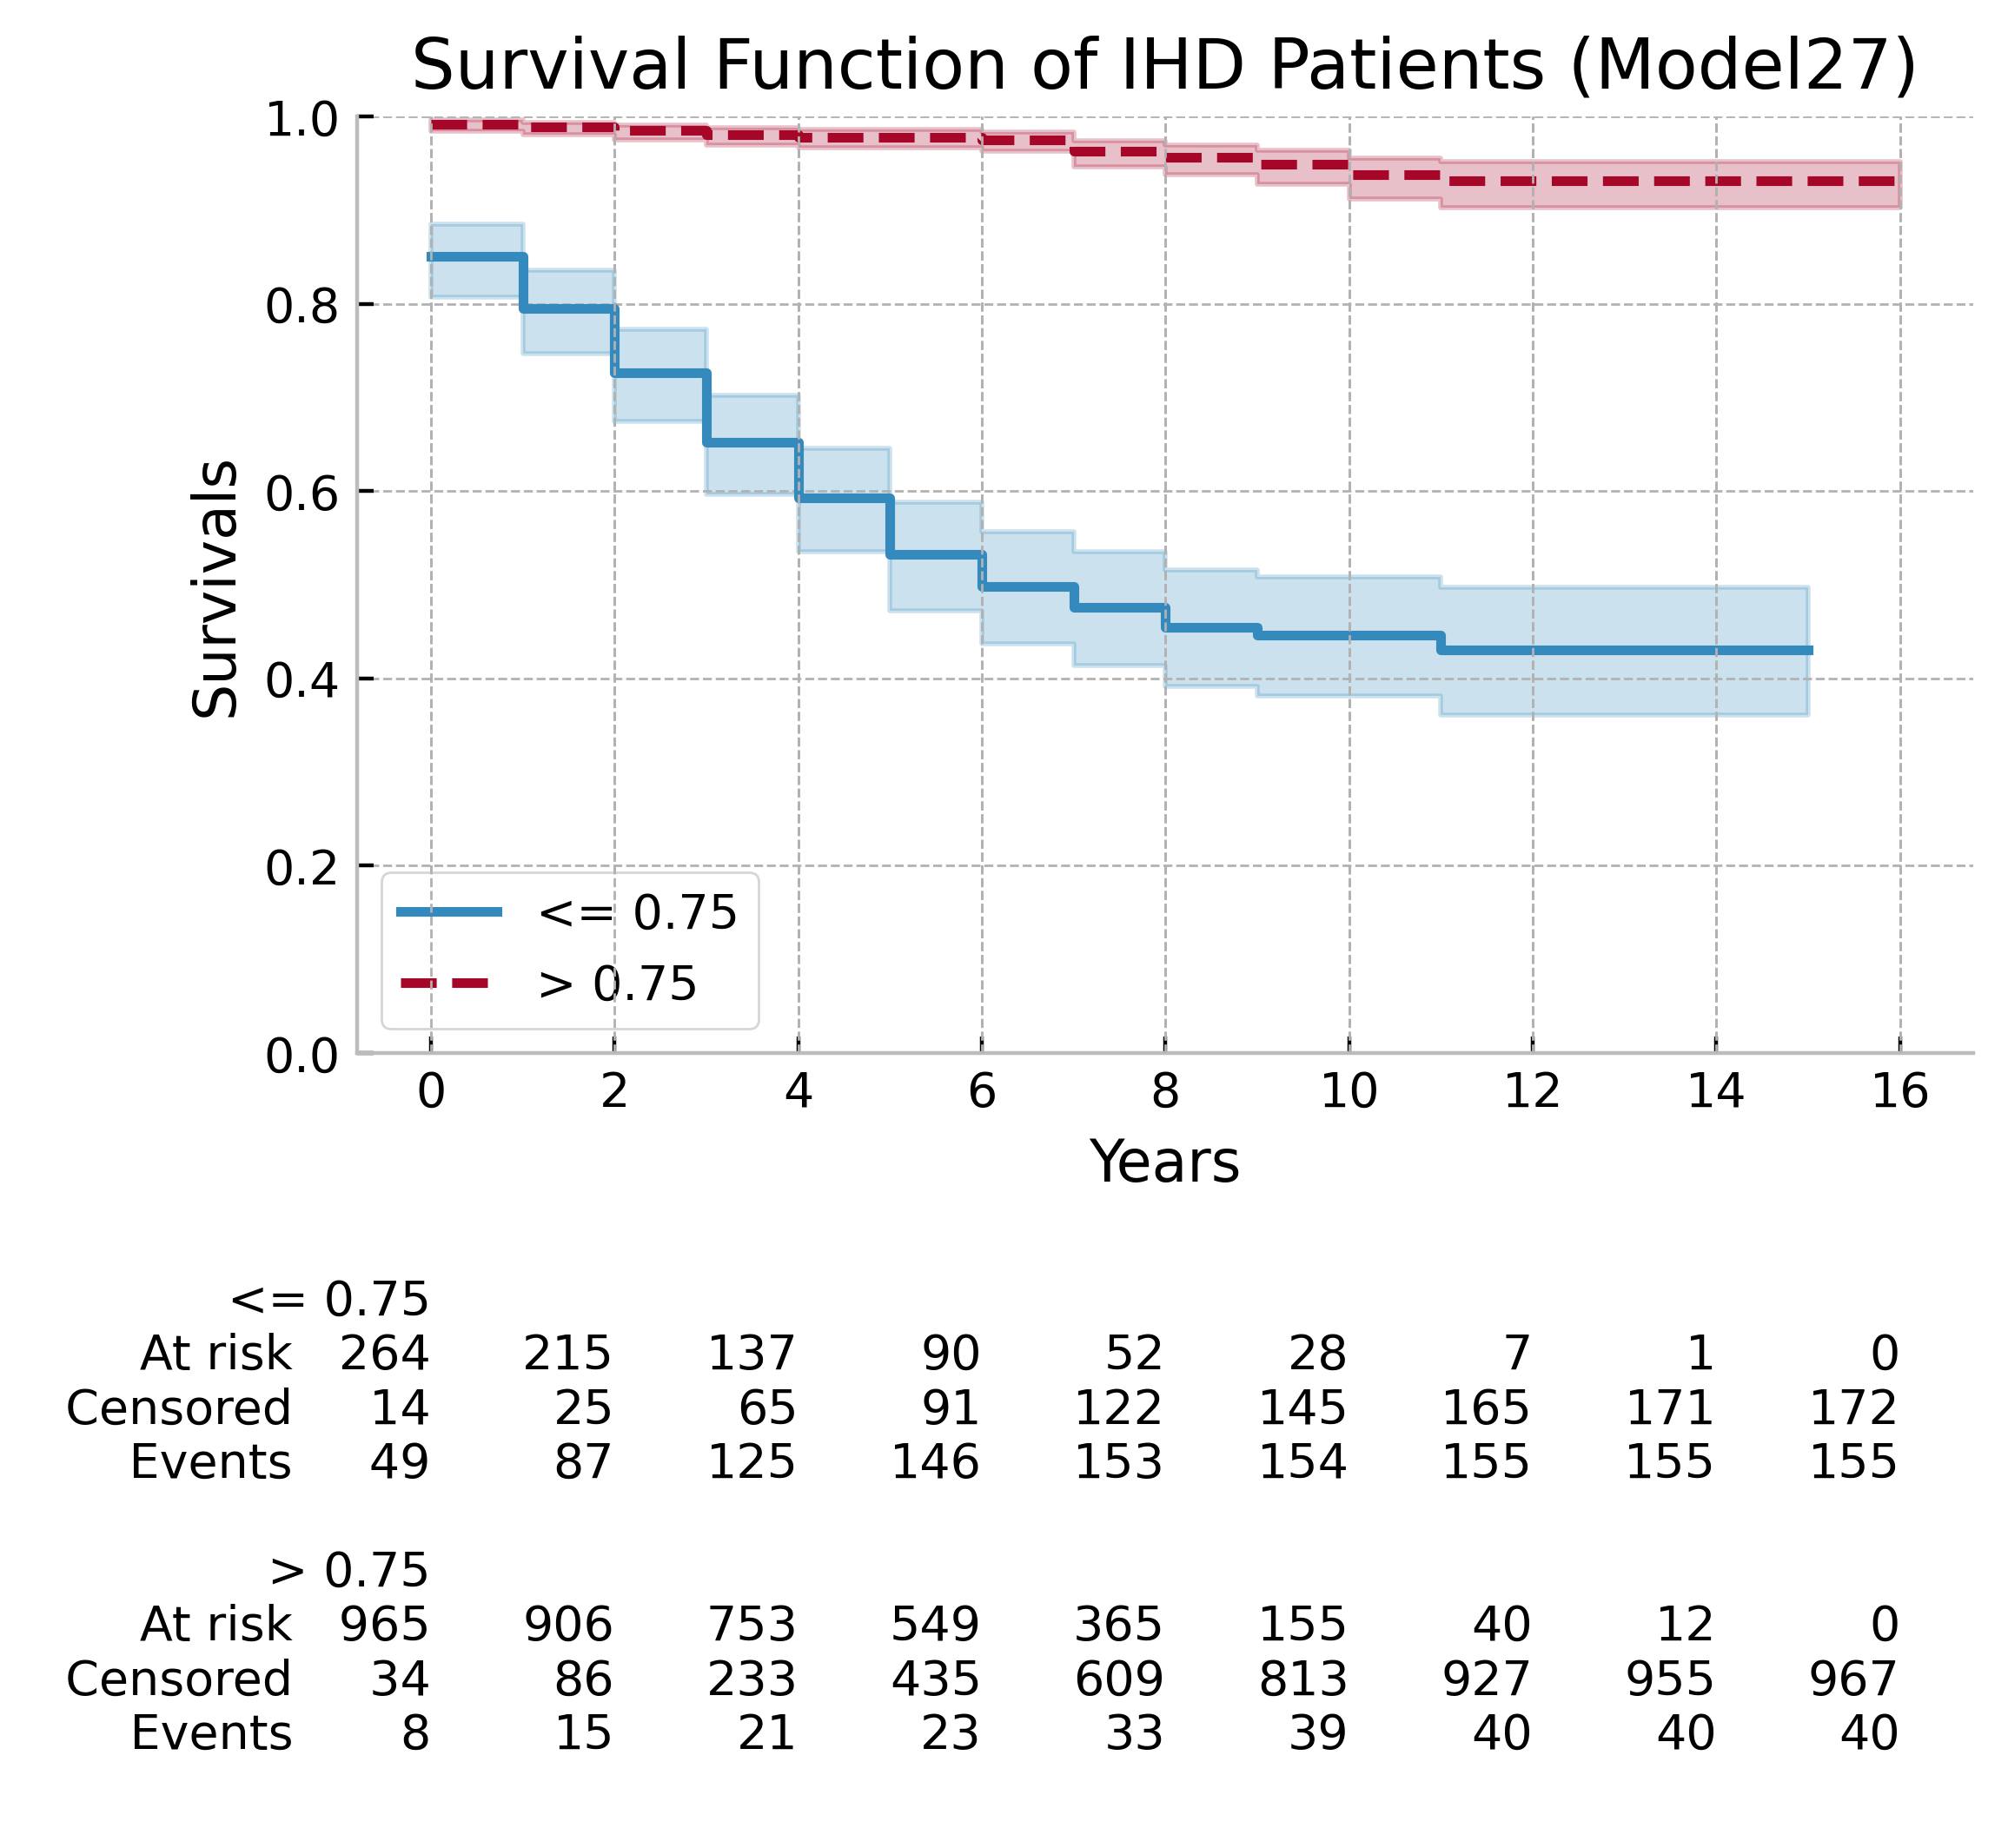

In [12]:
# Plots
fig = plt.figure(figsize=(6, 3.5), dpi=400) 
fig_dims = (1, 1)
fig.subplots_adjust(hspace=1, wspace=0.2)
threshold = 0.75 # median of ModelOutput is 0.911
plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_test_pred, threshold=threshold, variable="Model27")
plt.savefig(f"{path_images}survival_model_27.png", bbox_inches="tight", dpi=400)
#plt.savefig(f"{path_images}survival_model_27.tiff", format="tiff", bbox_inches="tight", dpi=400)

## COX Regression and p-value 


In [13]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')

# Model 27 all features
df_test_pred = df.drop(list(set(df.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
df_test_pred = df_test_pred.drop(["Survive7Y", "Death7Y"],axis=1)


In [14]:
df_test_pred.columns, len(df_test_pred.columns) 

(Index(['Gender (Male = 1)', 'Age', 'TSH', 'fT3', 'fT4', 'Euthyroid',
        'Subclinical primary hypothyroidism (SCH)',
        'Subclinical primary hyperthyroidism\n(SCT)', 'Low T3', 'Ipotiroidismo',
        'Ipertiroidismo', 'Angina', 'Previous CABG', 'Previous PCI',
        'Previous Myocardial Infarction', 'Acute Myocardial Infarction',
        'Angiography', 'Vessels', 'Documented resting \nor exertional ischemia',
        'Post-ischemic Dilated\nCardiomyopathy', 'Smoke\nHistory of smoke',
        'Diabetes\nHistory of diabetes',
        'Hypertension\nHistory of hypertension',
        'Dyslipidemia\nHystory of dyslipidemia', 'Atrial Fibrillation', 'fe',
        'duration', 'observed', 'ModelOutput'],
       dtype='object'),
 29)

Univariate

In [15]:
#i = 17
for key in range(0,26):
    cph = CoxPHFitter()
    cph.fit(df_test_pred.loc[:, [df_test_pred.columns[key], "duration", "observed"]], duration_col='duration', event_col='observed')
    #cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
    print(f"{df_test_pred.columns[key]}: {cph.concordance_index_} {cph.summary['p']}")
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
print(f"ML Indicator (27 variables): {cph.concordance_index_}")

Gender (Male = 1): 0.5024123032358137 covariate
Gender (Male = 1)    0.767252
Name: p, dtype: float64
Age: 0.7113750128444137 covariate
Age    1.682539e-22
Name: p, dtype: float64
TSH: 0.5717623514329473 covariate
TSH    8.729533e-08
Name: p, dtype: float64
fT3: 0.6563226321017376 covariate
fT3    1.540360e-10
Name: p, dtype: float64
fT4: 0.5765967441245982 covariate
fT4    0.222761
Name: p, dtype: float64
Euthyroid: 0.6261712882090728 covariate
Euthyroid    1.123278e-11
Name: p, dtype: float64
Subclinical primary hypothyroidism (SCH): 0.5380023389065857 covariate
Subclinical primary hypothyroidism (SCH)    0.000036
Name: p, dtype: float64
Subclinical primary hyperthyroidism
(SCT): 0.5054117796730424 covariate
Subclinical primary hyperthyroidism\n(SCT)    0.294238
Name: p, dtype: float64
Low T3: 0.571603325357564 covariate
Low T3    6.679250e-07
Name: p, dtype: float64
Ipotiroidismo: 0.5181191863736673 covariate
Ipotiroidismo    0.000516
Name: p, dtype: float64
Ipertiroidismo: 0.503545

Multivariate Top 27 variables + Model 27

In [12]:
cph = CoxPHFitter()
cph.fit(df_test_pred, duration_col='duration', event_col='observed')
cph.print_summary()

/opt/anaconda3/envs/ml_buzi/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1601: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.661. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(
/opt/anaconda3/envs/ml_buzi/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 1334 total observations, 1139 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 1334
number of events observed = 195
   partial log-likelihood = -1119.51
         time fit was run = 2024-07-04 15:14:06 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Gender (Male = 1)                             0.08       1.08       0.18            -0.26             0.42                 0.77                 1.53
Age                                           0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
TSH                                          -0.03       0.97       0.02            -0.06            -0.00                 0.94                 1.00
fT3                                          -0.01       0.99       0.12            -0.24             0.22                 0.79                 1.25
fT4                                          -0.04       0.96       0.03            -0.09             0.01                 0.91                 1.01
Euthyroid                                   -11.90       0.00    1501.18         -2954.15          2930.35                 0.00                  inf
Subclinical primary hypothyroidism (SCH)    -11.50       0.00    1501.18         -2953.75          2930.75                 0.00                  inf
Subclinical primary hyperthyroidism\n(SCT)  -12.26       0.00    1501.18         -2954.51          2929.99                 0.00                  inf
Low T3                                      -12.01       0.00    1501.18         -2954.26          2930.24                 0.00                  inf
Ipotiroidismo                               -11.15       0.00    1501.18         -2953.40          2931.10                 0.00                  inf
Ipertiroidismo                              -10.59       0.00    1501.18         -2952.84          2931.66                 0.00                  inf
Angina                                       -0.25       0.78       0.17            -0.58             0.08                 0.56                 1.08
Previous CABG                                -0.41       0.67       0.26            -0.92             0.10                 0.40                 1.11
Previous PCI                                  0.05       1.05       0.24            -0.41             0.52                 0.66                 1.68
Previous Myocardial Infarction                0.26       1.30       0.20            -0.13             0.66                 0.88                 1.93
Acute Myocardial Infarction                   0.38       1.46       0.30            -0.22             0.97                 0.80                 2.65
Angiography                                  -0.29       0.75       0.21            -0.70             0.11                 0.50                 1.12
Vessels                                       0.08       1.08       0.10            -0.11             0.27                 0.90                 1.31
Documented resting \nor exertional ischemia   0.00       1.00       0.19            -0.37             0.38                 0.69                 1.47
Post-ischemic Dilated\nCardiomyopathy        -0.32       0.72       0.26            -0.83             0.18                 0.44                 1.20
Smoke\nHistory of smoke                       0.02       1.02       0.18            -0.33             0.37                 0.72                 1.44
Diabetes\nHistory of diabetes                 0.40       1.49       0.17             0.07             0.72                 1.08                 2.06
Hypertension\nHistory of hypertension         0.06      

Multivariate all variables

In [13]:
df_feat = df_test_pred.drop(columns=["ModelOutput"])
cph = CoxPHFitter()
cph.fit(df_feat, duration_col='duration', event_col='observed')
cph.print_summary()
cph.concordance_index_


/opt/anaconda3/envs/ml_buzi/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1601: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.661. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(
/opt/anaconda3/envs/ml_buzi/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 1334 total observations, 1139 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 1334
number of events observed = 195
   partial log-likelihood = -1202.91
         time fit was run = 2024-07-04 15:15:15 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Gender (Male = 1)                             0.19       1.21       0.17            -0.14             0.52                 0.87                 1.69
Age                                           0.06       1.06       0.01             0.04             0.08                 1.05                 1.08
TSH                                          -0.00       1.00       0.02            -0.04             0.03                 0.97                 1.03
fT3                                          -0.52       0.59       0.17            -0.86            -0.19                 0.42                 0.83
fT4                                           0.01       1.01       0.02            -0.03             0.05                 0.97                 1.05
Euthyroid                                    -4.38       0.01    1118.72         -2197.04          2188.27                 0.00                  inf
Subclinical primary hypothyroidism (SCH)     -3.72       0.02    1118.72         -2196.37          2188.94                 0.00                  inf
Subclinical primary hyperthyroidism\n(SCT)   -4.57       0.01    1118.72         -2197.22          2188.09                 0.00                  inf
Low T3                                       -4.02       0.02    1118.72         -2196.68          2188.64                 0.00                  inf
Ipotiroidismo                                -3.97       0.02    1118.72         -2196.63          2188.68                 0.00                  inf
Ipertiroidismo                               -2.71       0.07    1118.72         -2195.37          2189.95                 0.00                  inf
Angina                                       -0.29       0.75       0.17            -0.62             0.04                 0.54                 1.04
Previous CABG                                 0.16       1.17       0.25            -0.32             0.64                 0.72                 1.91
Previous PCI                                  0.27       1.30       0.23            -0.19             0.73                 0.82                 2.07
Previous Myocardial Infarction                0.03       1.03       0.20            -0.36             0.42                 0.70                 1.52
Acute Myocardial Infarction                  -0.23       0.80       0.29            -0.80             0.34                 0.45                 1.41
Angiography                                  -0.43       0.65       0.20            -0.83            -0.04                 0.44                 0.96
Vessels                                       0.16       1.18       0.09            -0.02             0.35                 0.98                 1.42
Documented resting \nor exertional ischemia  -0.06       0.94       0.19            -0.43             0.31                 0.65                 1.37
Post-ischemic Dilated\nCardiomyopathy         0.30       1.34       0.24            -0.18             0.77                 0.84                 2.16
Smoke\nHistory of smoke                      -0.15       0.86       0.17            -0.48             0.18                 0.62                 1.20
Diabetes\nHistory of diabetes                 0.50       1.65       0.16             0.19             0.82                 1.21                 2.27
Hypertension\nHistory of hypertension        -0.12      

0.8182209630619125